# breast_Linear_XGboost_Lasso_Ridge_modeling
DC

#### This notebook:
* Load the EWAS aging data selecting for whole blood data and the 2259n ranked cpgs by XGboost importance
* Fit Linear Regression, XGboost, Lasso, and Ridge models predicting age using the top 1000 cpgs
* Test models on Test data
* Save models
* Fit Linear Regression, XGboost, Lasso, and Ridge models predicting age using the top 100 cpgs
* Test models on Test data
* Save models

#### Conclusions:
* Best Model Ridge with top 1000 cpgs, MAE = 3.73 on test data
* Other Models not bad
* Surprising XGboost not better than linear models


#### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import os
import pickle
import warnings
warnings.simplefilter('ignore')
plt.rcdefaults()

#### Import our modules

In [2]:
import age_predict.Loading_EWAS_Aging_Data as le
import age_predict.Regression as rg
import age_predict.Pickle_unpickle as pu

In [3]:
# View working directory
os.getcwd()

'/Users/dcox/Desktop/EWAS-organized/breast/modeling'

In [35]:
data_path = '../feature_selection/'
cpg_path = '../saved_features/'
save_models_path = '../saved_models/'
save_blood_model_path = '../../blood/saved_models/'

#### Get Saved imputed whole blood data 2259 cpgs

In [5]:
df_train = pd.read_csv(data_path + 'df_p_working_breast_ranked.csv', index_col=0)
df_test = pd.read_csv(data_path +  'df_p_saved_breast_ranked.csv', index_col=0)

#### Get Saved blood cpg rankings

In [6]:
cpgs_XGboost_breast_ranked = pu.get_pickled_object(cpg_path + 'cpgs_XGboost_breast_ranked')

In [7]:
top_100 = cpgs_XGboost_breast_ranked[:100]
top_1000 = cpgs_XGboost_breast_ranked[:1000]

In [67]:
s = pd.Series(list(df_train.age) + list(df_test.age))

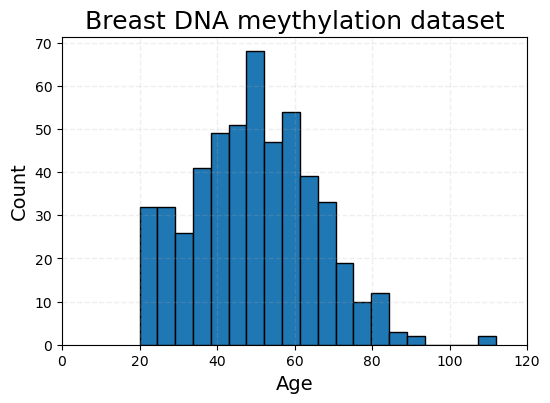

In [71]:
# Histogram of ages in train data
plt.figure(figsize=(6,4))
s.hist(bins=20,histtype='bar', ec='black' )
plt.xlabel('Age', fontsize=14)
plt.xlim(0,120)
plt.ylabel('Count', fontsize=14)
plt.grid(True, lw=1, ls = '--', alpha=0.2)
plt.title('Breast DNA meythylation dataset', fontsize=18)
plt.show()

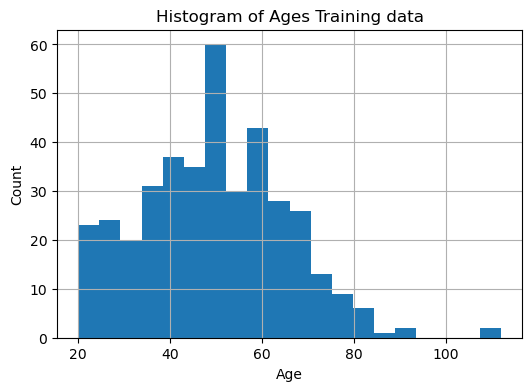

In [8]:
# Histogram of ages in train data
plt.figure(figsize=(6,4))
df_train.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Training data')
plt.show()

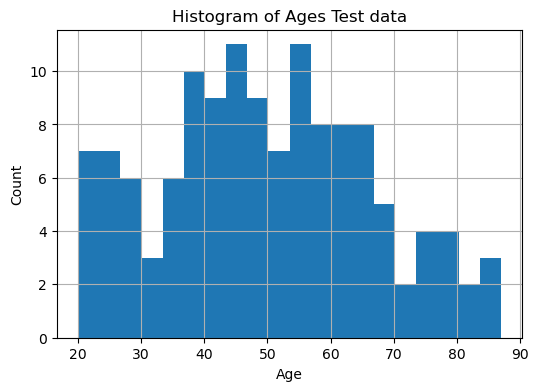

In [9]:
# Histogram of ages in saved data
plt.figure(figsize=(6,4))
df_test.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Test data')
plt.show()

In [10]:
df_train

,tissue,age,cg04880546,cg23606718,cg03036557,cg03545227,cg05708550,cg16867657,cg25410668,cg00065935,cg12373771,cg04084157,cg25090514,cg08904363,cg01644850,cg19401340,cg22736354,cg10806820,cg05917988,cg25105633,cg14911690,cg27320127,cg08318076,cg00702638,cg21801378,cg08097417,cg21186299,cg12451852,cg06580318,cg11229185,cg07846081,cg10820926,cg13612447,cg21424782,cg02338222,cg23156348,cg20119148,cg24315421,cg00460776,cg15936446,cg21832447,cg14674720,cg26885220,cg16909962,cg12678562,cg11071401,cg02650266,cg12204897,cg23998119,cg02383785,...,cg06911113,cg00051179,cg26230275,cg16691898,cg18637847,cg09257796,cg15920791,cg04200485,cg20027050,cg10318510,cg19302722,cg02892595,cg09684066,cg06644634,cg08162780,cg08538369,cg06624020,cg05950192,cg22865769,cg20641865,cg01591152,cg27366162,cg21305068,cg19217463,cg24428760,cg08712068,cg16333846,cg08350797,cg05817202,cg15164472,cg03207674,cg26898958,cg14989988,cg23849078,cg07865600,ch.1.156669547F,cg06905984,cg20263901,cg14205519,cg03062002,cg04060163,cg07568751,cg17220161,cg26071806,cg16612072,cg17437852,cg02997061,cg17552801,cg05617973,cg08005774
TCGA-BH-A1FG-11B-12D-A13T-05,breast,88,0.322,0.296,0.313,0.305,0.251,0.715,0.596,0.174,0.227,0.175,0.247,0.208000,0.083,0.119,0.322,0.228,0.262,0.774,0.177,0.176,0.187,0.181,0.158,0.231,0.107,0.106,0.137,0.206,0.119,0.178,0.104,0.077,0.039,0.281,0.271000,0.063000,0.198000,0.178,0.947,0.224,0.135,0.221,0.294,0.403,0.250,0.136,0.308,0.216,...,0.141,0.078,0.073,0.870,0.025,0.129,0.133,0.949,0.022,0.238,0.045,0.039,0.830,0.891,0.031,0.970,0.864,0.828,0.496,0.955,0.420,0.106,0.697,0.531,0.047,0.043,0.762,0.917,0.847,0.854,0.901,0.056,0.277,0.024,0.023,0.086,0.080000,0.252,0.818,0.061,0.124,0.038,0.225,0.024,0.042,0.069,0.152,0.118,0.019,0.118
GSM1658467,breast,76,0.233,0.237,0.044,0.323,0.221,0.558,0.413,0.172,0.161,0.159,0.172,0.120082,0.014,0.079,0.136,0.217,0.072,0.904,0.163,0.117,0.213,0.016,0.053,0.112,0.051,0.372,0.091,0.176,0.082,0.208,0.183,0.022,0.024,0.057,0.271423,0.220097,0.109441,0.187,0.952,0.096,0.029,0.070,0.101,0.228,0.242,0.072,0.309,0.204,...,0.116,0.117,0.130,0.908,0.068,0.131,0.075,0.973,0.018,0.354,0.015,0.017,0.892,0.863,0.027,0.977,0.903,0.851,0.490,0.994,0.415,0.103,0.903,0.438,0.049,0.011,0.844,0.928,0.752,0.908,0.843,0.033,0.208,0.015,0.055,0.094,0.072000,0.412,0.810,0.159,0.099,0.040,0.031,0.081,0.018,0.052,0.174,0.029,0.058,0.137
GSM2719528,breast,76,0.229,0.192,0.146,0.247,0.190,0.667,0.618,0.134,0.217,0.169,0.142,0.101000,0.031,0.080,0.286,0.208,0.159,0.809,0.099,0.170,0.120,0.086,0.055,0.226,0.058,0.121,0.113,0.169,0.100,0.131,0.081,0.042,0.037,0.104,0.252000,0.142000,0.145000,0.138,0.962,0.220,0.044,0.089,0.158,0.331,0.092,0.081,0.191,0.187,...,0.084,0.060,0.152,0.902,0.057,0.135,0.144,0.977,0.013,0.185,0.026,0.041,0.725,0.774,0.095,0.977,0.921,0.739,0.572,0.943,0.645,0.178,0.688,0.650,0.040,0.020,0.624,0.923,0.828,0.813,0.939,0.038,0.345,0.027,0.026,0.110,0.080000,0.417,0.839,0.038,0.099,0.016,0.186,0.051,0.015,0.061,0.108,0.139,0.033,0.146
GSM1658512,breast,81,0.161,0.186,0.081,0.197,0.135,0.456,0.519,0.132,0.124,0.136,0.123,0.165000,0.042,0.027,0.234,0.182,0.079,0.823,0.153,0.143,0.090,0.081,0.038,0.121,0.008,0.346,0.090,0.156,0.111,0.130,0.056,0.033,0.140,0.044,0.243000,0.216000,0.158000,0.089,0.944,0.179,0.039,0.040,0.089,0.235,0.046,0.037,0.221,0.132,...,0.121,0.076,0.109,0.880,0.069,0.185,0.183,0.956,0.032,0.281,0.024,0.020,0.830,0.889,0.080,0.996,0.905,0.742,0.531,0.994,0.729,0.124,0.816,0.532,0.051,0.050,0.692,0.949,0.860,0.920,0.919,0.048,0.439,0.010,0.038,0.105,0.079000,0.308,0.782,0.022,0.174,0.035,0.087,0.577,0.038,0.050,0.199,0.134,0.045,0.110
TCGA-BH-A204-11A-53D-A161-05,breast,81,0.460,0.198,0.239,0.222,0.210,0.669,0.655,0.192,0.373,0.252,0.227,0.279000,0.026,0.086,0.315,0.188,0.176,0.863,0.174,0.177,0.132,0.136,0.103,0.189,0.076,0.056,0.101,0.289,0.147,0.177,0.112,0.057,0.011,0.124,0.496000,0.220097,0.235000,0.157,0.952,0.236,0.102,0.138,0.296,0.352,0.153,0.094,0.302,0.227,...,0.081,0.116,0.209,0.894,0.04

In [11]:
df_test

,tissue,age,cg04880546,cg23606718,cg03036557,cg03545227,cg05708550,cg16867657,cg25410668,cg00065935,cg12373771,cg04084157,cg25090514,cg08904363,cg01644850,cg19401340,cg22736354,cg10806820,cg05917988,cg25105633,cg14911690,cg27320127,cg08318076,cg00702638,cg21801378,cg08097417,cg21186299,cg12451852,cg06580318,cg11229185,cg07846081,cg10820926,cg13612447,cg21424782,cg02338222,cg23156348,cg20119148,cg24315421,cg00460776,cg15936446,cg21832447,cg14674720,cg26885220,cg16909962,cg12678562,cg11071401,cg02650266,cg12204897,cg23998119,cg02383785,...,cg06911113,cg00051179,cg26230275,cg16691898,cg18637847,cg09257796,cg15920791,cg04200485,cg20027050,cg10318510,cg19302722,cg02892595,cg09684066,cg06644634,cg08162780,cg08538369,cg06624020,cg05950192,cg22865769,cg20641865,cg01591152,cg27366162,cg21305068,cg19217463,cg24428760,cg08712068,cg16333846,cg08350797,cg05817202,cg15164472,cg03207674,cg26898958,cg14989988,cg23849078,cg07865600,ch.1.156669547F,cg06905984,cg20263901,cg14205519,cg03062002,cg04060163,cg07568751,cg17220161,cg26071806,cg16612072,cg17437852,cg02997061,cg17552801,cg05617973,cg08005774
GSM2719547,breast,33,0.090,0.097,0.069,0.111,0.088,0.584,0.471,0.096,0.089,0.125,0.096,0.068,0.016,0.037,0.158,0.122,0.050,0.745,0.086,0.088,0.071,0.010,0.030,0.163,0.006,0.138,0.046,0.164,0.053,0.158,0.038,0.012,0.047,0.019,0.205,0.368000,0.018000,0.060,0.964,0.115,0.100,0.014,0.065,0.270,0.050,0.020,0.151,0.133,...,0.203,0.055,0.178,0.719,0.073,0.146,0.270,0.962,0.017,0.216,0.008,0.065,0.780,0.834,0.124,0.957,0.879,0.830,0.623,0.960,0.481,0.216,0.645,0.534,0.053,0.037,0.713,0.905,0.823,0.734,0.932,0.044,0.372,0.032,0.036,0.113,0.073,0.338,0.754,0.022,0.101,0.033,0.230,0.041,0.017,0.025,0.154,0.113,0.045,0.205
GSM2719533,breast,56,0.316,0.184,0.196,0.240,0.215,0.682,0.530,0.133,0.223,0.157,0.196,0.170,0.055,0.075,0.291,0.182,0.199,0.811,0.121,0.176,0.141,0.115,0.054,0.229,0.062,0.108,0.138,0.216,0.115,0.150,0.087,0.034,0.024,0.188,0.284,0.212000,0.206000,0.178,0.954,0.193,0.077,0.098,0.195,0.369,0.089,0.111,0.249,0.189,...,0.163,0.052,0.145,0.792,0.073,0.177,0.166,0.988,0.012,0.214,0.034,0.055,0.791,0.772,0.051,0.987,0.796,0.765,0.584,0.947,0.616,0.203,0.780,0.607,0.033,0.035,0.740,0.903,0.857,0.823,0.938,0.050,0.315,0.030,0.026,0.130,0.054,0.369,0.798,0.053,0.156,0.020,0.251,0.043,0.019,0.046,0.220,0.171,0.061,0.140
TCGA-E9-A1ND-11A-43D-A145-05,breast,75,0.250,0.205,0.136,0.259,0.124,0.681,0.609,0.134,0.163,0.146,0.168,0.122,0.059,0.113,0.287,0.180,0.144,0.769,0.117,0.155,0.113,0.109,0.094,0.168,0.049,0.124,0.095,0.167,0.079,0.166,0.047,0.028,0.035,0.107,0.296,0.085000,0.111000,0.132,0.956,0.164,0.082,0.103,0.164,0.348,0.182,0.087,0.191,0.161,...,0.121,0.078,0.125,0.887,0.045,0.095,0.161,0.965,0.020,0.174,0.026,0.054,0.802,0.862,0.048,0.979,0.903,0.816,0.638,0.942,0.584,0.176,0.636,0.521,0.025,0.031,0.710,0.923,0.875,0.761,0.913,0.053,0.333,0.020,0.033,0.097,0.077,0.349,0.810,0.008,0.115,0.028,0.252,0.045,0.018,0.048,0.161,0.127,0.025,0.120
GSM2892591,breast,65,0.218,0.189,0.064,0.270,0.120,0.693,0.647,0.126,0.179,0.217,0.173,0.159,0.016,0.070,0.304,0.271,0.140,0.775,0.122,0.192,0.134,0.036,0.064,0.268,0.019,0.147,0.080,0.186,0.128,0.162,0.028,0.022,0.049,0.048,0.313,0.337000,0.100000,0.148,0.899,0.232,0.112,0.060,0.125,0.355,0.134,0.041,0.156,0.207,...,0.101,0.063,0.219,0.786,0.059,0.205,0.184,0.943,0.015,0.240,0.031,0.025,0.728,0.745,0.059,0.955,0.783,0.697,0.566,0.918,0.534,0.255,0.658,0.568,0.072,0.026,0.634,0.860,0.814,0.770,0.932,0.051,0.481,0.009,0.028,0.195,0.054,0.384,0.879,0.037,0.163,0.028,0.387,0.053,0.007,0.033,0.070,0.201,0.040,0.140
GSM2892578,breast,84,0.318,0.211,0.186,0.369,0.211,0.756,0.612,0.183,0.293,0.210,0.236,0.202,0.049,0.092,0.394,0.390,0.201,0.749,0.246,0.336,0.142,0.067,0.048,0.315,0.087,0.112,0.124,0.372,0.194,0.135,0.085,0.021,0.030,0.075,0.331,0.130000,0.181000,0.392,0.935,0.367,0.082,0.084,0.161,0.374,0.154,0.084,0.179,0.237,...,0.107,0.115,0.175,0.801,0.068,0.341,0.131,0.870,0.012,0.212,0.024,0.028,0.720,0.779,0.10

In [12]:
from sklearn.model_selection import train_test_split
X = df_train[top_1000]
y = df_train.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

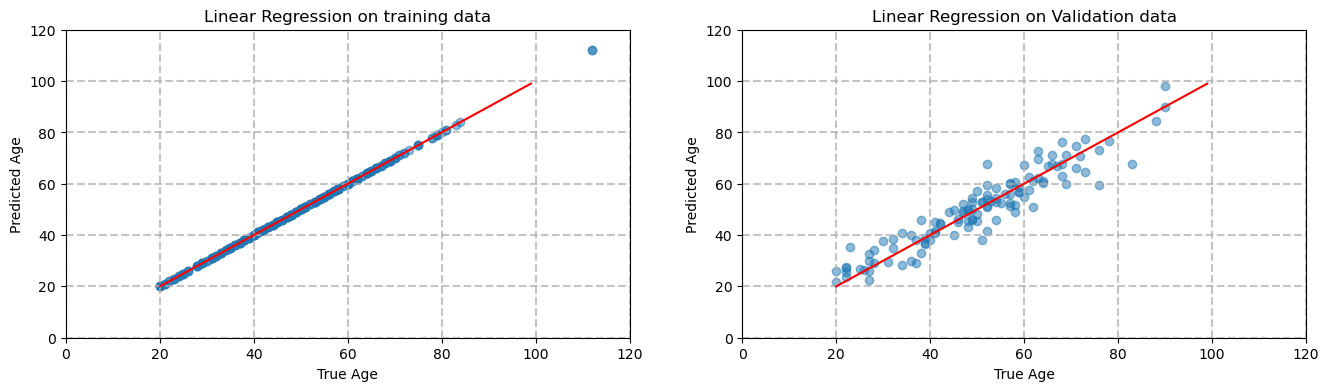

The rms on the training data is 0.000 years
The rms on the validation data is 5.320 years
The r^2 on the training data is 1.000
The r^2 on the validation data is 0.888
The MAe on the training data is 0.000 years
The MAE on the validation data is 4.078


In [13]:
breast_mod_1000, rms_train, rms_test, r2_train, r2_test = rg.linear_regress(X_train, y_train, X_test, y_test, plot=True)

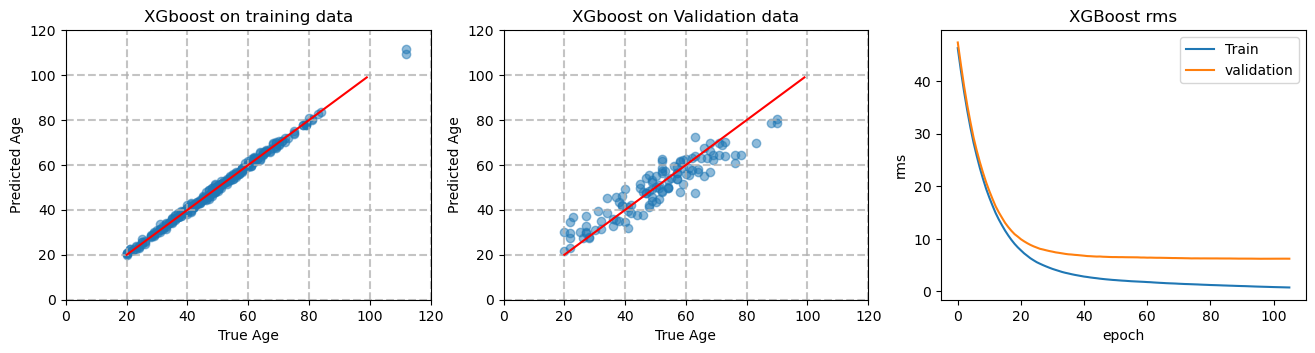

The number of training epochs was 106
The rms on the training data is 0.915 years
The rms on the validation data is 6.227 years
The r^2 on the training data is 0.997
The r^2 on the validation data is 0.846
The MAE on the training data is 0.730 years
The MAE on the validation data is 4.952 years


In [14]:
breast_mod_XG_1000, rms_train, rms_test, r2_train, r2_test, feature_importances_ = rg.xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10)

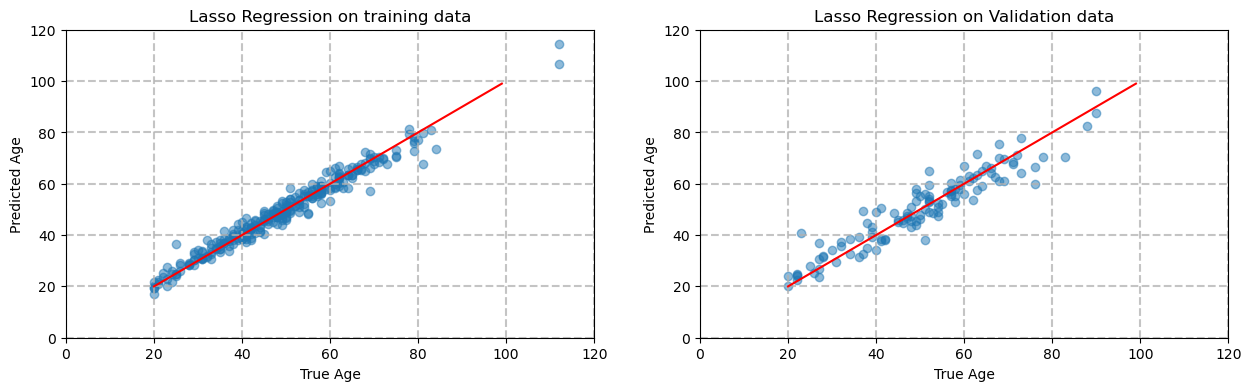

The rms on the training data is 2.859 years
The rms on the validation data is 5.277 years
The r^2 on the training data is 0.967
The r^2 on the validation data is 0.889
The MAE on the training data is 2.109 years
The MAE on the validation data is 3.974 years
Optimal alpha from CV = 0.01


In [15]:
breast_mod_lasso_1000, rms_train, rms_test, r2_train, r2_test = rg.lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

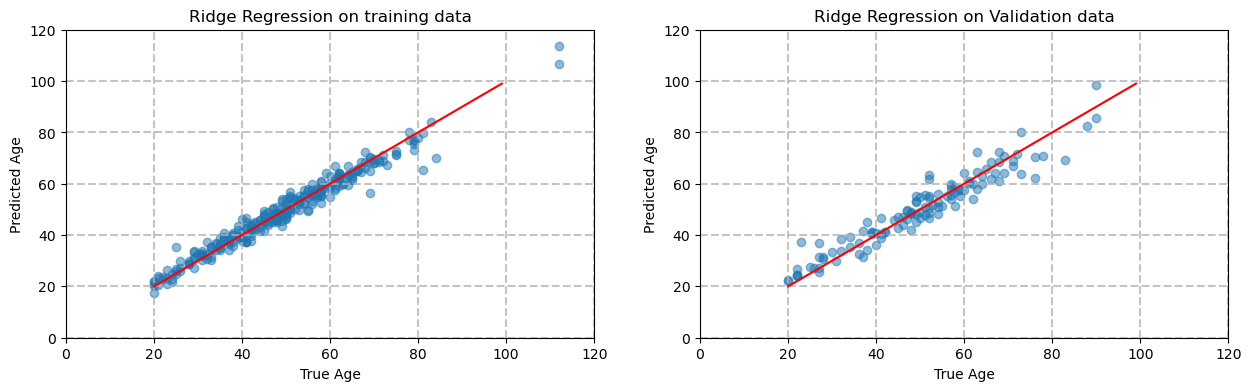

The rms on the training data is 2.938 years
The rms on the validation data is 4.547 years
The r^2 on the training data is 0.965
The r^2 on the validation data is 0.918
The MAE on the training data is 2.162 years
The MAE on the validation data is 3.474 years
Optimal alpha from CV = 1.0


In [16]:
breast_mod_ridge_1000, rms_train, rms_test, r2_train, r2_test = rg.ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

In [17]:
# Save models
pu.pickle_object(breast_mod_1000, save_models_path + 'breast_mod_1000')
pu.pickle_object(breast_mod_ridge_1000, save_models_path + 'breast_mod_ridge_1000')
pu.pickle_object(breast_mod_lasso_1000, save_models_path + 'breast_mod_lasso_1000')
pu.pickle_object(breast_mod_XG_1000, save_models_path + 'breast_mod_XG_1000')

pickled as ../saved_models/breast_mod_1000
pickled as ../saved_models/breast_mod_ridge_1000
pickled as ../saved_models/breast_mod_lasso_1000
pickled as ../saved_models/breast_mod_XG_1000


In [18]:
X_test = df_test[top_1000]
y_test = df_test.age

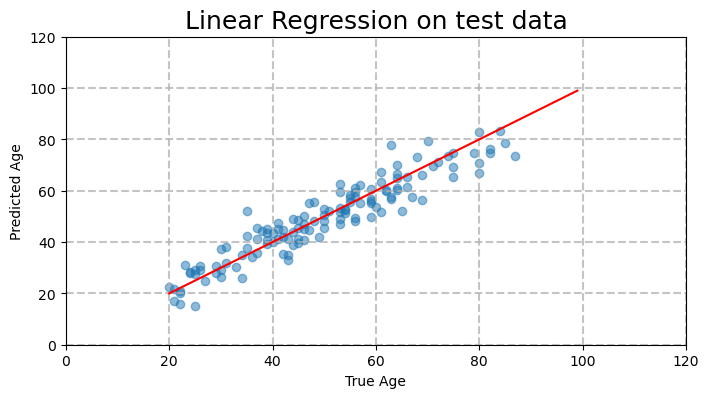

The MSE on Test data is 31.096 years
The rms on Test data is 5.576 years
The r^2 on Test data is 0.886
The mae on Test data is 4.388 years
The correlation on the Test data true-predicted is 0.942


In [19]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, breast_mod_1000, mtype='Linear Regression', figsize=(8,4))

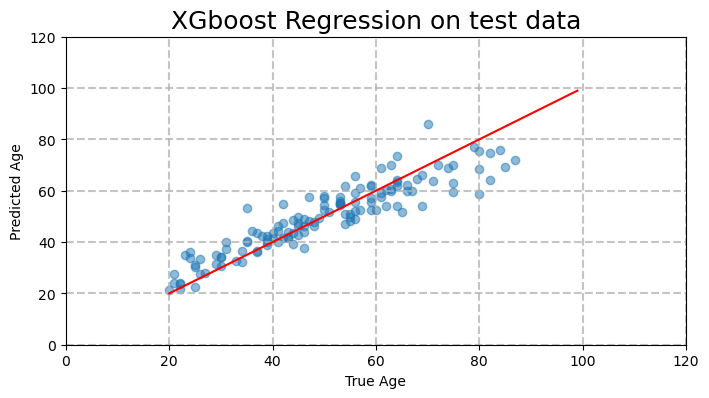

The MSE on Test data is 44.550 years
The rms on Test data is 6.675 years
The r^2 on Test data is 0.837
The mae on Test data is 5.047 years
The correlation on the Test data true-predicted is 0.921


In [20]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, breast_mod_XG_1000, mtype='XGboost Regression', figsize=(8,4))

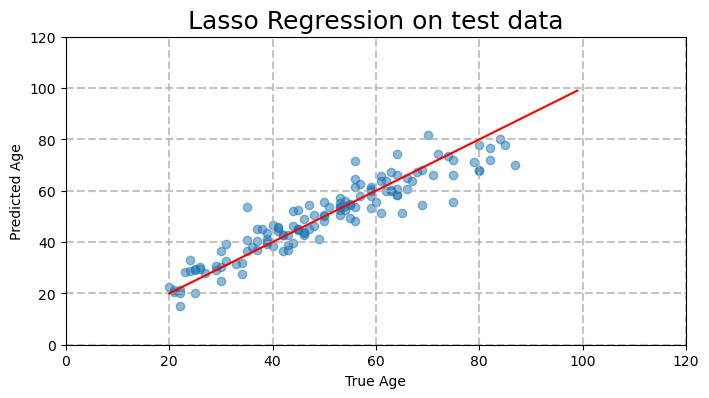

The MSE on Test data is 33.825 years
The rms on Test data is 5.816 years
The r^2 on Test data is 0.876
The mae on Test data is 4.280 years
The correlation on the Test data true-predicted is 0.937


In [21]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, breast_mod_lasso_1000, mtype='Lasso Regression', figsize=(8,4))

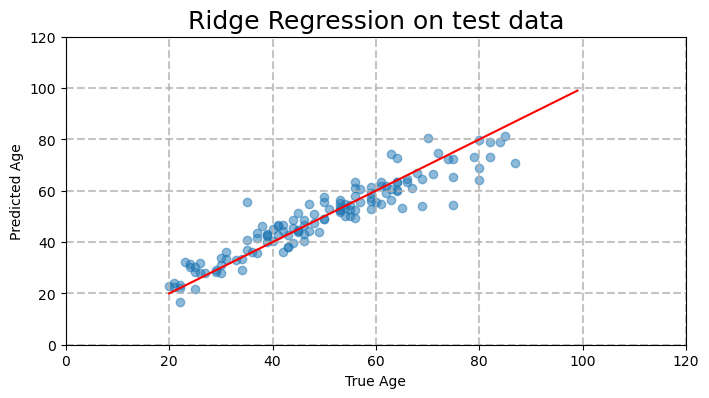

The MSE on Test data is 31.466 years
The rms on Test data is 5.609 years
The r^2 on Test data is 0.885
The mae on Test data is 4.086 years
The correlation on the Test data true-predicted is 0.943


In [22]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, breast_mod_ridge_1000, mtype='Ridge Regression', figsize=(8,4))

In [23]:
from sklearn.model_selection import train_test_split
X = df_train[top_100]
y = df_train.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

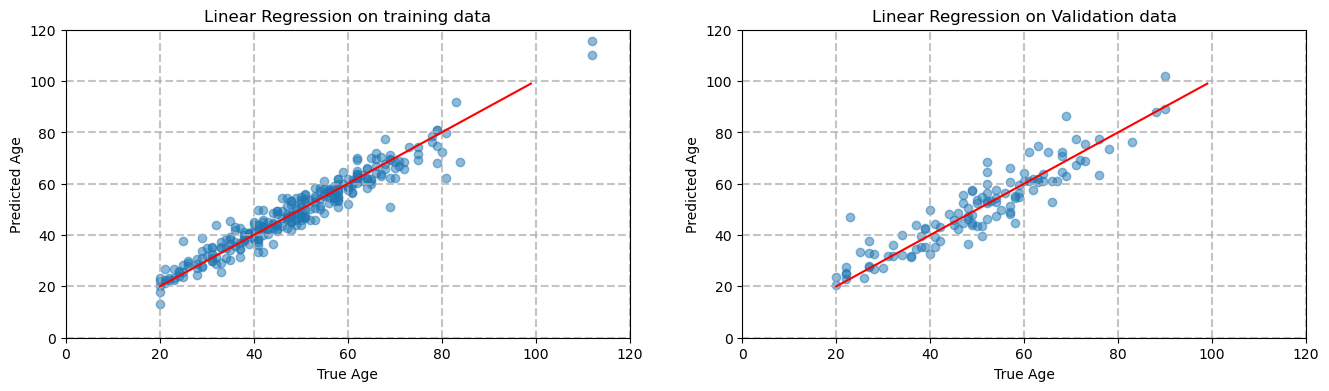

The rms on the training data is 4.242 years
The rms on the validation data is 6.280 years
The r^2 on the training data is 0.928
The r^2 on the validation data is 0.843
The MAe on the training data is 3.174 years
The MAE on the validation data is 4.752


In [24]:
breast_mod_100, rms_train, rms_test, r2_train, r2_test = rg.linear_regress(X_train, y_train, X_test, y_test, plot=True)

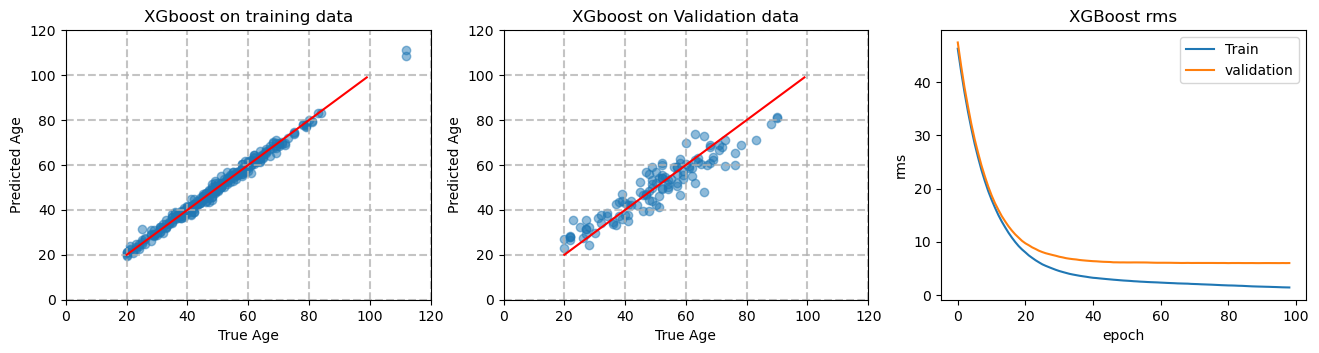

The number of training epochs was 99
The rms on the training data is 1.577 years
The rms on the validation data is 5.986 years
The r^2 on the training data is 0.990
The r^2 on the validation data is 0.858
The MAE on the training data is 1.242 years
The MAE on the validation data is 4.827 years


In [25]:
breast_mod_XG_100, rms_train, rms_test, r2_train, r2_test, feature_importances_ = rg.xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10)

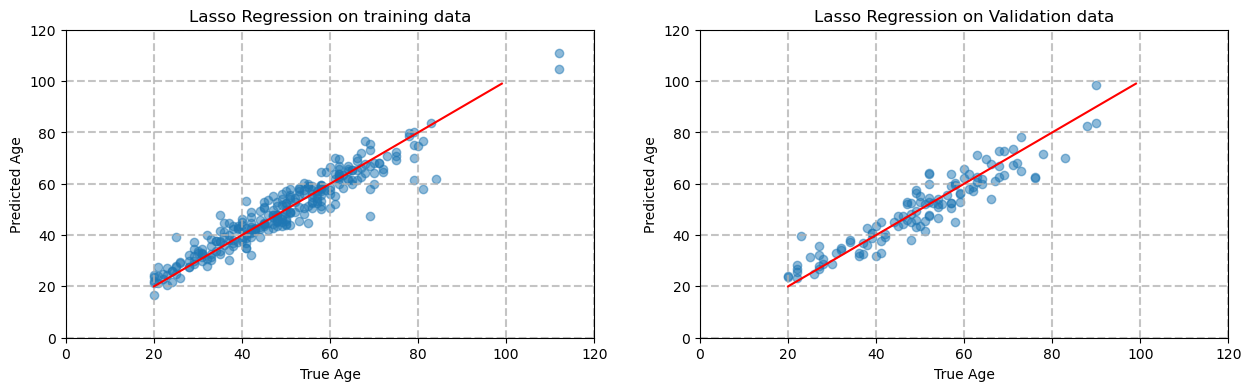

The rms on the training data is 4.953 years
The rms on the validation data is 5.531 years
The r^2 on the training data is 0.901
The r^2 on the validation data is 0.878
The MAE on the training data is 3.653 years
The MAE on the validation data is 4.410 years
Optimal alpha from CV = 0.01


In [26]:
breast_mod_lasso_100, rms_train, rms_test, r2_train, r2_test = rg.lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

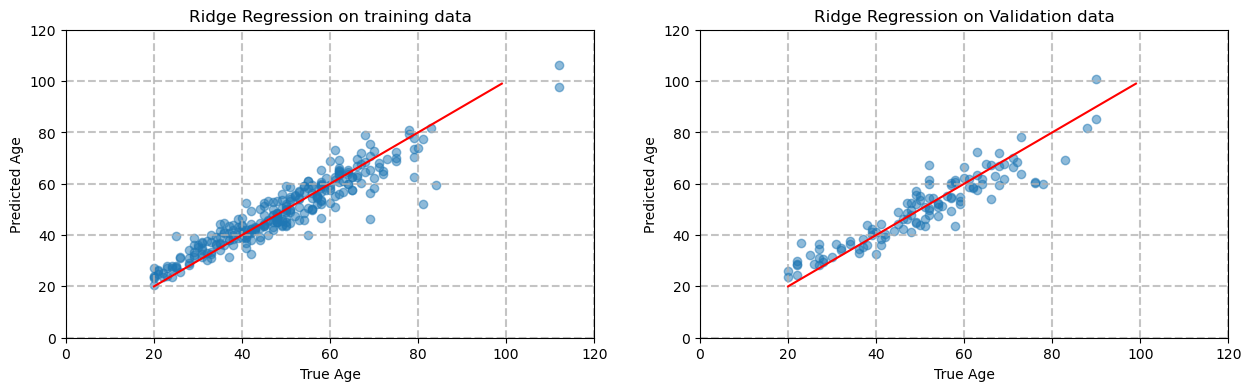

The rms on the training data is 5.524 years
The rms on the validation data is 5.890 years
The r^2 on the training data is 0.877
The r^2 on the validation data is 0.862
The MAE on the training data is 4.061 years
The MAE on the validation data is 4.621 years
Optimal alpha from CV = 1.0


In [27]:
breast_mod_ridge_100, rms_train, rms_test, r2_train, r2_test = rg.ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

In [28]:
# Save models
pu.pickle_object(breast_mod_100, save_models_path + 'breast_mod_100')
pu.pickle_object(breast_mod_ridge_100, save_models_path + 'breast_mod_ridge_100')
pu.pickle_object(breast_mod_lasso_100, save_models_path + 'breast_mod_lasso_100')
pu.pickle_object(breast_mod_XG_100, save_models_path + 'breast_mod_XG_100')

pickled as ../saved_models/breast_mod_100
pickled as ../saved_models/breast_mod_ridge_100
pickled as ../saved_models/breast_mod_lasso_100
pickled as ../saved_models/breast_mod_XG_100


In [29]:
X_test = df_test[top_100]
y_test = df_test.age

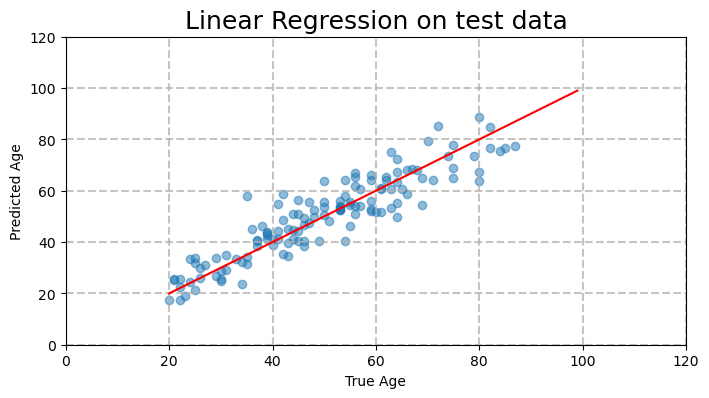

The MSE on Test data is 45.501 years
The rms on Test data is 6.745 years
The r^2 on Test data is 0.834
The mae on Test data is 5.253 years
The correlation on the Test data true-predicted is 0.915


In [30]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, breast_mod_100, mtype='Linear Regression', figsize=(8,4))

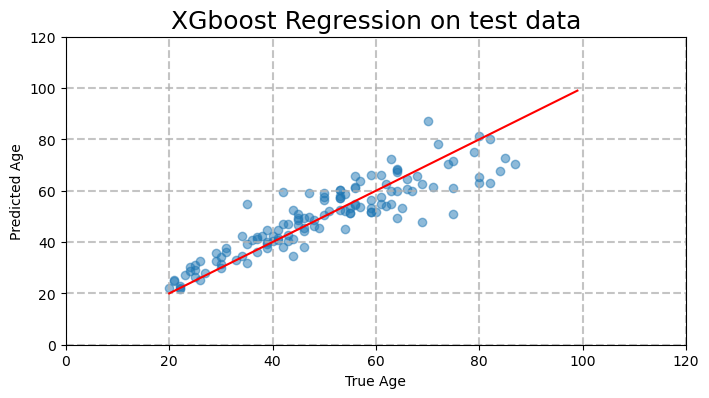

The MSE on Test data is 53.043 years
The rms on Test data is 7.283 years
The r^2 on Test data is 0.806
The mae on Test data is 5.450 years
The correlation on the Test data true-predicted is 0.899


In [31]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, breast_mod_XG_100, mtype='XGboost Regression', figsize=(8,4))

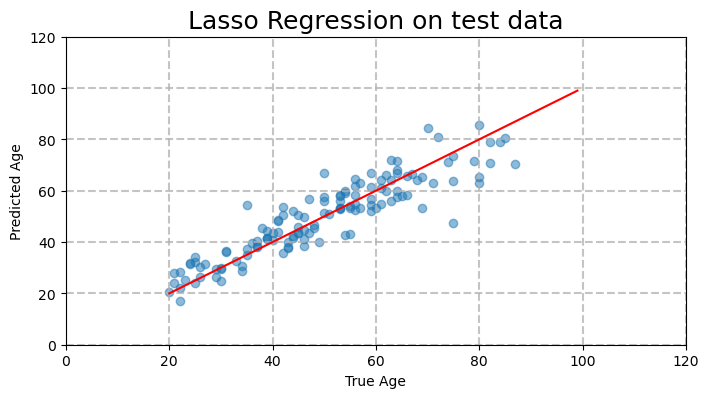

The MSE on Test data is 46.524 years
The rms on Test data is 6.821 years
The r^2 on Test data is 0.830
The mae on Test data is 5.175 years
The correlation on the Test data true-predicted is 0.911


In [32]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, breast_mod_lasso_100, mtype='Lasso Regression', figsize=(8,4))

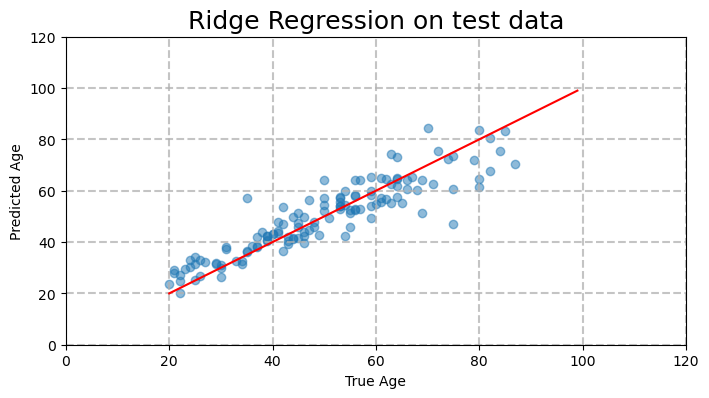

The MSE on Test data is 47.960 years
The rms on Test data is 6.925 years
The r^2 on Test data is 0.825
The mae on Test data is 5.134 years
The correlation on the Test data true-predicted is 0.909


In [33]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, breast_mod_ridge_100, mtype='Ridge Regression', figsize=(8,4))

###  Applying blood ridge 1000 model to breast data

In [64]:
X_test = df_test[top_1000]
y_test = df_test.age

In [65]:
wb_mod_ridge_1000 = pu.get_pickled_object(save_blood_model_path + 'wb_mod_ridge_1000')
wb_mod_ridge_100 = pu.get_pickled_object(save_blood_model_path + 'wb_mod_ridge_100')

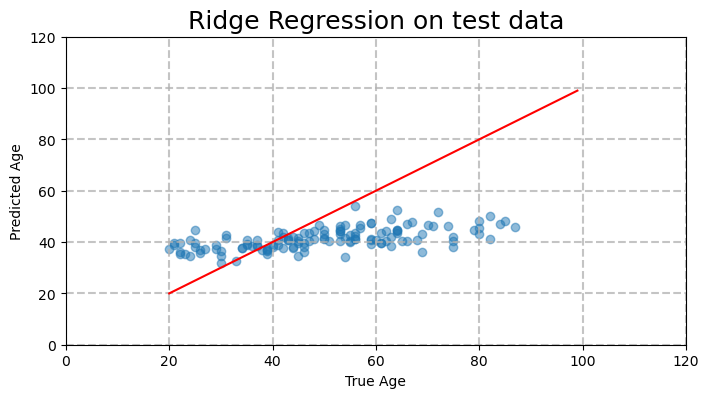

The MSE on Test data is 280.878 years
The rms on Test data is 16.759 years
The r^2 on Test data is -0.027
The mae on Test data is 13.262 years
The correlation on the Test data true-predicted is 0.612


In [66]:
preds, MSE, rms, r2, MAE, r_corr = rg.test_model_on_heldout_data(X_test, y_test, wb_mod_ridge_1000, mtype='Ridge Regression', figsize=(8,4))